## 1. 加载数据，并划分出训练集和测试集

In [17]:
import csv
import random
# 加载数据，返回属性集和训练集
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
# 逐行读取，将数据整理成 {{'pclass': ···, 'survived': ···, ···}, {'pclass': ···, 'survived': ···, ···}, ···} 的形式
        reader = csv.DictReader(f)

        data = []
        for row in reader:
# 逐行提取数据，这里仅提取(性别，仓位，同行兄弟姐妹数，同行子女父母数)这几个指标决策是否存活，选出的样本应该在这几个指标中无缺省值
            if row['sex'] and row['pclass'] and row['sibsp'] and row['parch'] and row['survived']:
                data.append([row['sex'], row['pclass'], row['sibsp'], row['parch'], row['survived']])
    return ['sex', 'pclass', 'sibsp', 'parch'], data

headers, data = load_data('titanic3.csv')
random.shuffle(data)
split_idx = int(len(data) * 0.7)
train_data = data[:split_idx]
test_data  = data[split_idx:]

## 2. 使用训练集来构建决策树，并输出决策树的结构

In [18]:
import math
from collections import Counter
# 计算信息熵
def entropy(data):
    label_counts = Counter(row[-1] for row in data)
    total = len(data)
    return -sum((count/total) * math.log2(count/total) for count in label_counts.values())

# 按给定特征划分数据
def split_data(data, index, value):
    return [row[:index] + row[index+1:] for row in data if row[index] == value]

# 选择信息增益最大的特征
def choose_best_feature(data):
    base_entropy = entropy(data)
    best_gain = 0
    best_feature = -1
    num_features = len(data[0]) - 1

    # 遍历每一个还未被使用的特征
    for i in range(num_features):
        values = set(row[i] for row in data)
        # 计算由当前特征取值划分样本的信息增益
        new_entropy = sum((len(subset := split_data(data, i, value)) / len(data)) * entropy(subset) for value in values)
        gain = base_entropy - new_entropy
        if gain > best_gain:
            best_gain = gain
            best_feature = i
    return best_feature

# 多数投票
def majority_class(class_list):
    return Counter(class_list).most_common(1)[0][0]

# 构建决策树
# 树的结构为：{ feature: { value1: subtree1, ... } } 或 叶子标签
def build_tree(data, labels):
    # 提取当前所有样本所属类别（存活 / 死亡）
    class_list = [row[-1] for row in data]

    # 若所有样本均为同一类别，直接将其标记为叶节点的值并返回
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]

    # 所有特征均用完，根据出现频率决定该叶子节点的值并返回
    if len(data[0]) == 1:
        return majority_class(class_list)

    best_feat = choose_best_feature(data)
    best_label = labels[best_feat]
    tree = {best_label: {}}
    feat_values = set(row[best_feat] for row in data)
    sub_labels = labels[:best_feat] + labels[best_feat+1:]

    for value in feat_values:
        subtree = build_tree(split_data(data, best_feat, value), sub_labels)
        tree[best_label][value] = subtree
    return tree

def print_tree(tree, prefix="", is_last=True):
    # 如果是根节点，由外部传入的 prefix=""
    if isinstance(tree, dict):
        # 只有一个根特征
        for idx, (feature, branches) in enumerate(tree.items()):
            connector = "\---" if prefix == "" else ("\---" if is_last else "+---")
            print(f"{prefix}{connector}{feature}")
            # 更新前缀
            child_prefix = prefix + ("    " if is_last else "|   ")
            # 遍历各分支
            for i, (value, subtree) in enumerate(branches.items()):
                value_connector = "+---" if i < len(branches)-1 else "\---"
                print(f"{child_prefix}{value_connector}{value}")
                # 递归打印子树
                next_prefix = child_prefix + ("|   " if i < len(branches)-1 else "    ")
                print_tree(subtree, next_prefix, is_last=(i == len(branches)-1))
    else:
        # 叶子标签
        connector = "\---"
        print(f"{prefix}{connector}{tree}")

tree = build_tree(train_data, headers)
print("构建的决策树：")
print_tree(tree)

构建的决策树：
\---sex
    +---female
    |   +---pclass
    |   |   +---2
    |   |   |   +---parch
    |   |   |   |   +---2
    |   |   |   |   |   \---1
    |   |   |   |   +---3
    |   |   |   |   |   \---1
    |   |   |   |   +---1
    |   |   |   |   |   +---sibsp
    |   |   |   |   |   |   +---2
    |   |   |   |   |   |   |   \---1
    |   |   |   |   |   |   +---1
    |   |   |   |   |   |   |   \---1
    |   |   |   |   |   |   \---0
    |   |   |   |   |   |       \---1
    |   |   |   |   \---0
    |   |   |   |       \---sibsp
    |   |   |   |           +---3
    |   |   |   |           |   \---1
    |   |   |   |           +---1
    |   |   |   |           |   \---1
    |   |   |   |           \---0
    |   |   |   |               \---1
    |   |   +---1
    |   |   |   +---parch
    |   |   |   |   +---2
    |   |   |   |   |   +---sibsp
    |   |   |   |   |   |   +---2
    |   |   |   |   |   |   |   \---1
    |   |   |   |   |   |   +---1
    |   |   |   |   |   |   |   

## 3. 使用决策树来预测测试集

In [19]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False
def classify(tree, labels, sample):
    # 如果到叶子节点，直接返回结果
    if not isinstance(tree, dict):
        return tree

    # 找到当前节点的特征，提取出样本的该特征值，找到对应的子树
    feature = next(iter(tree))
    feature_index = labels.index(feature)
    feature_value = sample[feature_index]
    subtree = tree[feature].get(feature_value)
    if subtree is None:
        return None  # 未知取值
    # 将样本去除该特征，送往对应的子树，递归查找
    sub_labels = labels[:feature_index] + labels[feature_index+1:]
    sub_sample = sample[:feature_index] + sample[feature_index+1:]
    return classify(subtree, sub_labels, sub_sample)

# 对数据集批量预测
def predict(tree, labels, data):
    return [classify(tree, labels, row[:-1]) for row in data]

# 预测
actual_test    = [row[-1] for row in test_data]
predicted_test = predict(tree, headers, test_data)

## 4. 对预测结果进行统计并可视化预测效果

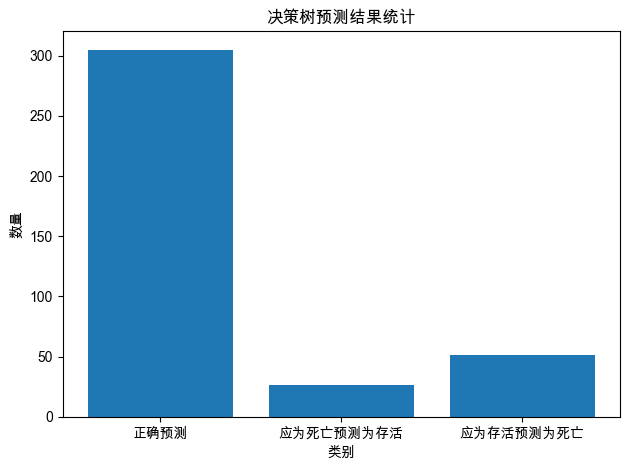

决策树分类准确率: 77.61%
在测试集上的结果：样本总数 393，TP=101, TN=204, FP=26, FN=51
准确率：79.84%，精确率：79.53%，召回率：66.45%，F1 分数：72.40%


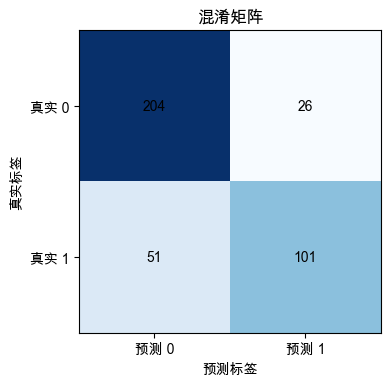

In [20]:
# 可视化预测结果
def plot_results(actual, predicted):
    correct = sum(1 for a, p in zip(actual, predicted) if p == a)
    zero_to_one = sum(1 for a, p in zip(actual, predicted) if a == '0' and p == '1')
    one_to_zero = sum(1 for a, p in zip(actual, predicted) if a == '1' and p == '0')
    categories = ['正确预测', '应为死亡预测为存活', '应为存活预测为死亡']
    counts = [correct, zero_to_one, one_to_zero]
    plt.figure()
    plt.bar(categories, counts)
    plt.title('决策树预测结果统计')
    plt.xlabel('类别')
    plt.ylabel('数量')
    plt.tight_layout()
    plt.show()
    print(f"决策树分类准确率: {correct / len(actual) * 100:.2f}%")

# 结果可视化
plot_results(actual_test, predicted_test)

# 计算混淆矩阵和评价指标
def evaluate(actual, pred):
    tp = tn = fp = fn = 0
    for a, p in zip(actual, pred):
        if a == '1' and p == '1':      tp += 1
        elif a == '0' and p == '0':    tn += 1
        elif a == '0' and p == '1':    fp += 1
        elif a == '1' and p == '0':    fn += 1
    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall    = tp / (tp + fn) if (tp + fn) else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return tp, tn, fp, fn, accuracy, precision, recall, f1

tp, tn, fp, fn, accuracy, precision, recall, f1 = evaluate(actual_test, predicted_test)
print(f"在测试集上的结果：样本总数 {len(test_data)}，TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print(f"准确率：{accuracy*100:.2f}%，精确率：{precision*100:.2f}%，召回率：{recall*100:.2f}%，F1 分数：{f1*100:.2f}%")

# 可视化混淆矩阵
import numpy as np
cm = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("混淆矩阵")
plt.xticks([0, 1], ['预测 0', '预测 1'])
plt.yticks([0, 1], ['真实 0', '真实 1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.tight_layout()
plt.show()